<PRE>
█▀█ ▄▀█ █▄░█ █▀▄ █▀█ █▀▄▀█   █▀▀ █▀█ █▀█ █▀▀ █▀ ▀█▀   █▀▀ █░░ ▄▀█ █▀ █▀ █ █▀▀ █ █▀▀ █▀█
█▀▄ █▀█ █░▀█ █▄▀ █▄█ █░▀░█   █▀░ █▄█ █▀▄ ██▄ ▄█ ░█░   █▄▄ █▄▄ █▀█ ▄█ ▄█ █ █▀░ █ ██▄ █▀▄
</PRE>

## Model lasy drzew decyzyjnych

### 1. Argumenty za przyjęciem modelu lasu drzew decyzyjnych:
- zdolność radzenia sobie z dużą liczbą cech
- ddolność uwzględniania nieliniowych relacji
- duża odporność na nadmierne dopasowanie
- łatwość interpretacji

### 2. Import bibliotek

In [16]:
# Standard libraries
import math
import logging
from collections import Counter
from typing import Any, Dict, Optional, Tuple

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn libraries for preprocessing and metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve

# Scikit-learn libraries for model selection
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score

# Scikit-learn libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Scikit-learn libraries for pipeline
from sklearn.pipeline import make_pipeline

# Imbalanced-learn libraries
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

### 3. Deklaracja funkcji - pobranie i przeskalowanie danych

In [17]:
def initialize_data(scaler_type: Optional[str] = None) -> Tuple[pd.DataFrame, pd.Series]:
    
    # Pobranie danych z plików .csv
    X = pd.read_csv('wineData.csv')
    y = pd.read_csv('wineRatings.csv')
    y = y.values.ravel()
    
    #Informacje o danych do logów
    logging.info(f"X shape: {X.shape}, y shape: {y.shape}")

    #Przeskalowanie danych przy użyciu obiektu MinMaxScaler
    if scaler_type in ["minmax", "standard"]:
        scaler = MinMaxScaler() if scaler_type == "minmax" else StandardScaler()
        X = scaler.fit_transform(X)
        logging.info(f"Data scaled using {scaler_type} scaler.")
    else:
        logging.info("No scaling applied.")

    return X, y

### 4. Deklaracja funkcji - podział danych, uczenie, hiperparametryzacja i ocena modelu

In [18]:
#Funkcja definiująca strategię próbkowania
def sampling_strategy(y):
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    return {class_label: max(int(0.40 * max_count), count) for class_label, count in zip(unique, counts)}

#Funkcja dzieląca dane na zbiór treningowy i testowy oraz nakladająca oversampler
def initialize_and_split_data(scaler_type: str, method: str = 'none') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = initialize_data(scaler_type)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if method == 'smote':
        strategy = sampling_strategy(y_train)
        oversampler = SMOTE(sampling_strategy=strategy, k_neighbors=2, random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
        logging.info(f"Applied {method} to handle class imbalance in the training data.")
    return X_train, X_test, y_train, y_test

#Funkcja ewaluująca model
def cross_validation_and_evaluation(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any], cv_splits: int = 5, random_state: int = 42) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list, Dict[str, Any]]:
    # Set the best parameters for the model
    model.set_params(**best_params)
    pipe = make_pipeline(model)

    # Perform cross-validation
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    cv_results = cross_validate(pipe, X_train, y_train, cv=kfold, return_train_score=True)
    logging.info(f"Cross-validation results: {cv_results}")


    logging.info(f"Mean accuracy score over all folds: {cv_results['test_score'].mean() * 100:.2f}%")
    logging.info(f"Mean training accuracy score over all folds: {cv_results['train_score'].mean() * 100:.2f}%")
    return cv_results, cv_results['test_score'].mean()

#Funkcja znajująca najlepsze hiperparametry
def optimize_hyperparameters(estimator, X_train: np.ndarray, y_train: np.ndarray, param_grid: Dict[str, Any], n_iter: int = 10, cv_splits: int = 5, random_state: int = 42) -> Dict[str, Any]:
    random_search = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, n_iter=n_iter, cv= cv_splits, scoring='accuracy', random_state=random_state, n_jobs=-1, verbose=2)
    random_search.fit(X_train, y_train)
    logging.info(f"Best accuracy score: {random_search.best_score_ * 100:.2f}%")
    logging.info(f"Best parameters: {random_search.best_params_}")
    return random_search.best_params_



### 5. Deklaracja funkcji - generacja wykresów

In [19]:
def generate_report(y_test: Any, y_pred: Any) -> Dict[str, Any]:
    # Determine unique classes
    classes = [3, 4, 5, 6, 7, 8]

    report = classification_report(y_test, y_pred, labels=classes, output_dict=True, zero_division=1)
    logging.info("Classification report:\n%s", classification_report(y_test, y_pred, labels=classes, zero_division=1))
    logging.info("Confusion matrix:\n%s", confusion_matrix(y_test, y_pred, labels=classes))
    return report

#Funkcja generująca histogram
def plot_histogram(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot.hist(ax=ax, alpha=0.5)
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.legend(['Actual', 'Predicted'])

#Funkcja generująca wykres przewidywań vs właściwych ocen wina
def plot_actual_vs_predicted(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot(ax=ax, marker='o')
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend(['Actual', 'Predicted'])

#Funkcja generująca raport klasyfikacji
def plot_classification_report(report: Dict[str, Any], ax: plt.Axes) -> None:
    report_df = pd.DataFrame(report).transpose().drop(columns='support')
    report_df.plot(kind='bar', ax=ax)
    ax.set_title('Classification Report Metrics')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

#Funkcja generująca macierz pomyłek
def plot_confusion_matrix(report: np.ndarray, classes: list, ax: plt.Axes) -> None:
    sns.heatmap(report, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, ax=ax, cmap='Blues')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

#Funkcja wywołująca wszystkie wykesy
def display_plots(y_fold_test: np.ndarray, y_pred: np.ndarray, report: Dict[str, Any], cv_results: Dict[str, Any], accuracy_without_optimization: float, accuracy_with_optimization: float) -> None:
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    classes = [3, 4, 5, 6, 7, 8]
    plot_actual_vs_predicted(y_fold_test, y_pred, axs[0, 0])
    plot_confusion_matrix(confusion_matrix(y_fold_test, y_pred, labels=classes), classes, axs[0, 1])
    plot_classification_report(report, axs[1, 0])
    plot_histogram(y_fold_test, y_pred, axs[2, 1])
    
    axs[1, 1].plot(cv_results['test_score'], label='Test Score')
    axs[1, 1].plot(cv_results['train_score'], label='Train Score')
    axs[1, 1].set_title('Cross-validation Results with Optimized Hyperparameters')
    axs[1, 1].set_xlabel('Fold Index')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    axs[2, 0].bar(['Without Optimization', 'With Optimization'], [accuracy_without_optimization, accuracy_with_optimization])
    axs[2, 0].set_title('Comparison of Model Performance')
    axs[2, 0].set_ylabel('Mean Accuracy Score')
    
    plt.tight_layout()
    plt.show()

### 6. Część głowna

2024-06-01 12:27:47,763 - INFO - X shape: (1503, 5), y shape: (1503,)
2024-06-01 12:27:47,769 - INFO - Data scaled using standard scaler.
2024-06-01 12:27:48,113 - INFO - Applied smote to handle class imbalance in the training data.
2024-06-01 12:27:48,114 - INFO - Data initialization and splitting complete.
2024-06-01 12:27:52,637 - INFO - Cross-validation results: {'fit_time': array([0.37403846, 0.53635979, 0.81907058, 0.78439093, 1.6594553 ]), 'score_time': array([0.00594926, 0.01826119, 0.02045441, 0.01792908, 0.06296444]), 'test_score': array([0.80327869, 0.7568306 , 0.76164384, 0.78356164, 0.79178082]), 'train_score': array([1., 1., 1., 1., 1.])}
2024-06-01 12:27:52,637 - INFO - Mean accuracy score over all folds: 77.94%
2024-06-01 12:27:52,637 - INFO - Mean training accuracy score over all folds: 100.00%


Fitting 5 folds for each of 10 candidates, totalling 50 fits


2024-06-01 12:28:04,125 - INFO - Best accuracy score: 75.54%
2024-06-01 12:28:04,126 - INFO - Best parameters: {'n_estimators': 250, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 90, 'bootstrap': True}
2024-06-01 12:28:08,979 - INFO - Cross-validation results: {'fit_time': array([1.15575075, 0.93528295, 0.84965777, 0.74802947, 0.78234005]), 'score_time': array([0.01982856, 0.02244973, 0.01836014, 0.01753521, 0.0205965 ]), 'test_score': array([0.79508197, 0.75136612, 0.75890411, 0.76986301, 0.78082192]), 'train_score': array([0.96577687, 0.96646133, 0.96511628, 0.96443228, 0.96169631])}
2024-06-01 12:28:08,979 - INFO - Mean accuracy score over all folds: 77.12%
2024-06-01 12:28:08,979 - INFO - Mean training accuracy score over all folds: 96.47%
2024-06-01 12:28:09,888 - INFO - Classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.12      0.08      0.10

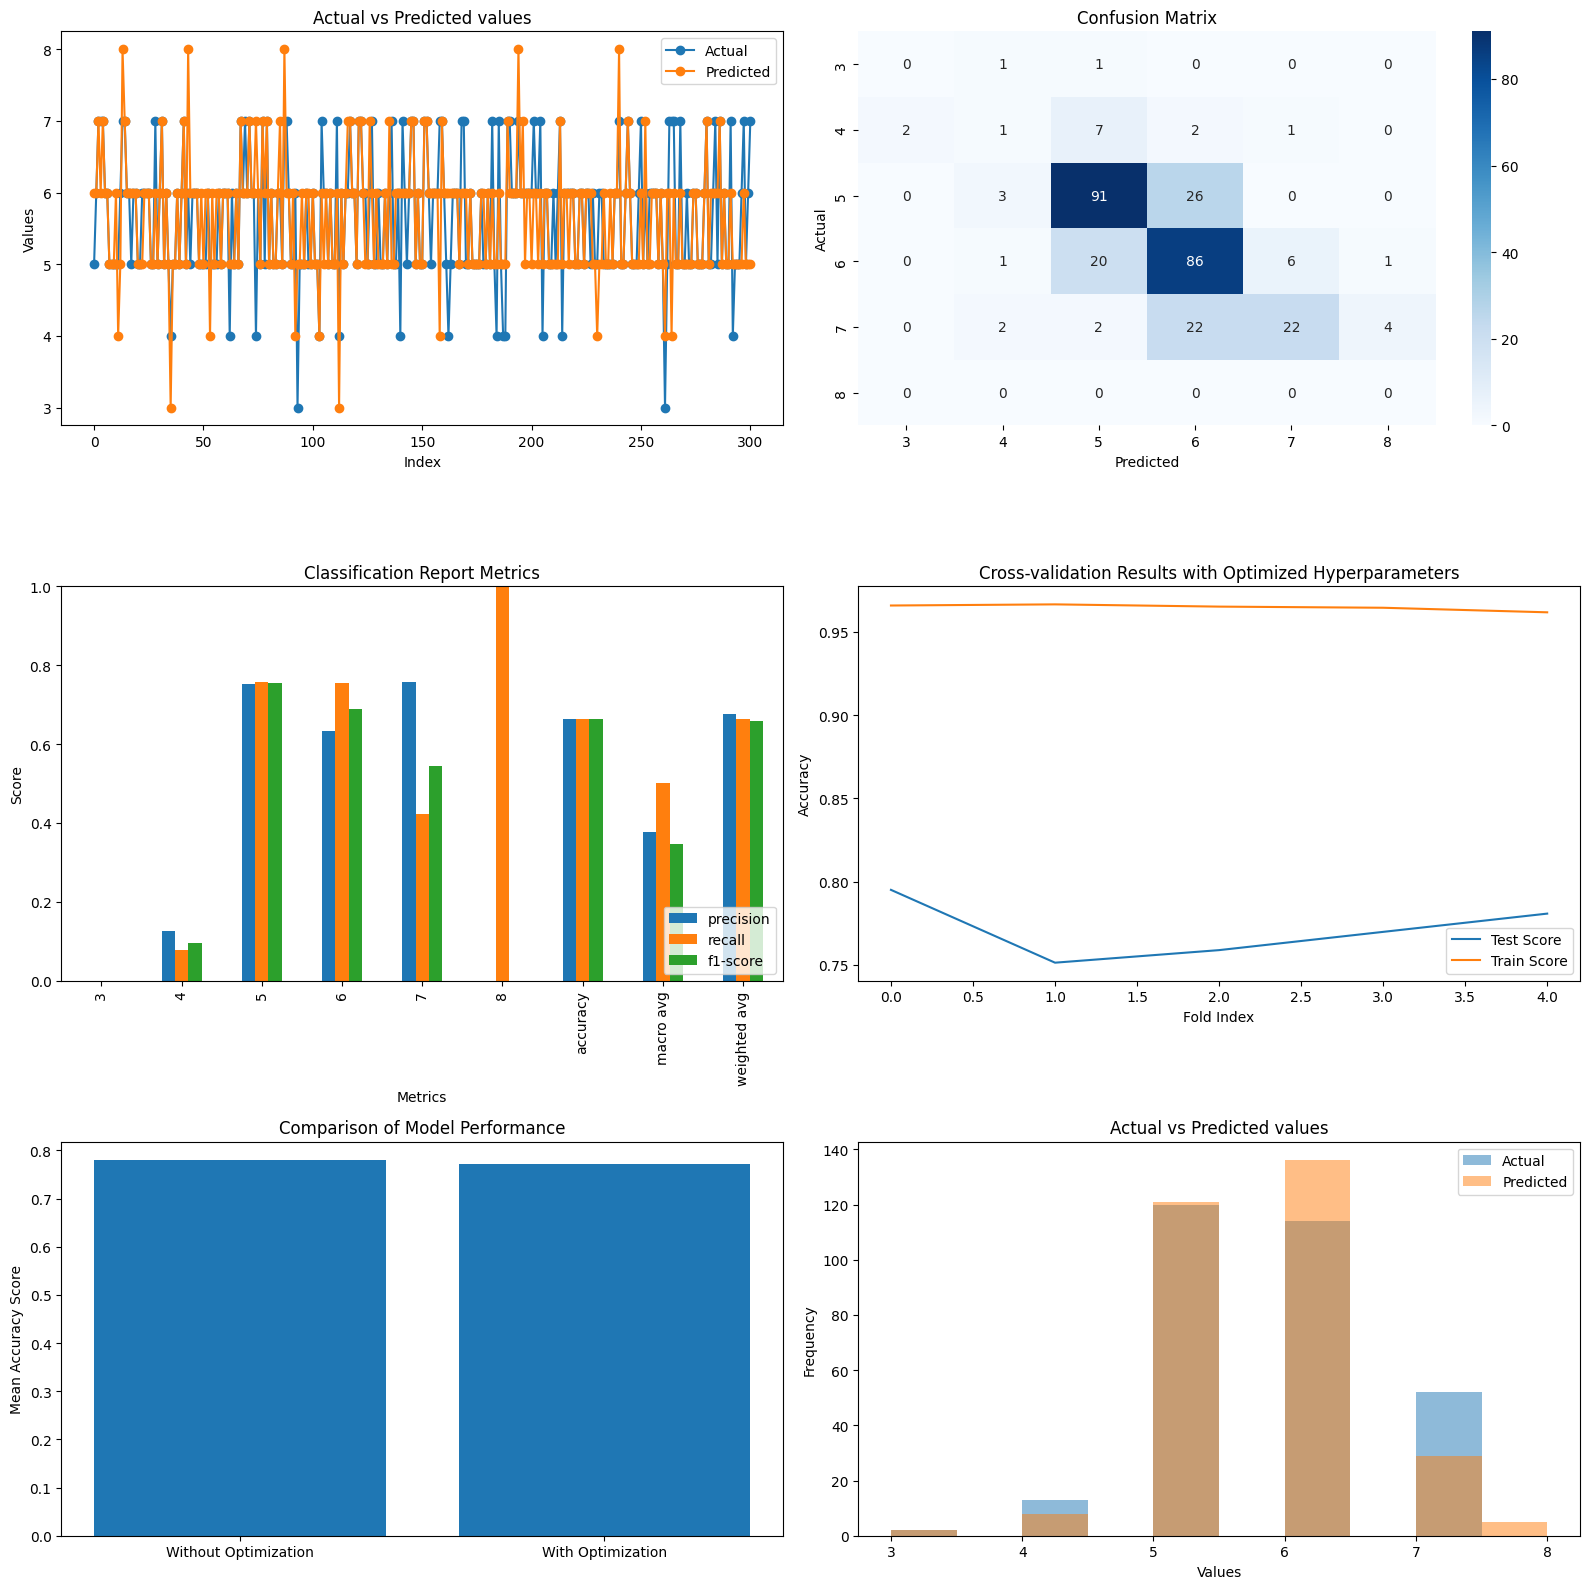

In [20]:

def random_forest_main():
    try:
        #Podział danych na zbior testowy i treningowy
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard", 'smote')
        logging.info("Data initialization and splitting complete.")

        #Utworzenie obiektu modelu
        rf = RandomForestClassifier()

        #Wytrenowanie i wstepna ocena modelu
        best_params = {}
        cv_results, accuracy_without_optimization = cross_validation_and_evaluation(X_train, y_train, rf, best_params)

        #Hiperparametryzacja
        param_grid = {
            'n_estimators': np.arange(50, 501, 50),  # number of trees in the forest
            'max_depth': [None] + list(np.arange(10, 110, 10)),  # maximum depth of the tree
            'min_samples_split': np.arange(2, 12, 2),  # minimum number of samples required to split an internal node
            'min_samples_leaf': np.arange(1, 12, 2),  # minimum number of samples required to be at a leaf node
            'max_features': ['sqrt', 'log2'],  # number of features to consider when looking for the best split
            'bootstrap': [True, False]  # whether bootstrap samples are used when building trees
        }
        estimator = RandomForestClassifier()
        best_params = optimize_hyperparameters(estimator, X_train, y_train, param_grid)

        #Walidacja krzyżowa modelu ze zoptymalizowanymi hiperparametrami
        cv_resultsOPT, accuracy_with_optimization = cross_validation_and_evaluation(X_train, y_train, rf, best_params)

        #Ponowne wyktrenowanie modelu, ale ze zoptymalizowanymi hiperparametrami
        rf.set_params(**best_params)
        rf.fit(X_train, y_train)

        #Predykcje na zbiorze testowym
        y_pred_optimized = rf.predict(X_test)

        #Generacja raportu dla modelu
        report_optimized = generate_report(y_test, y_pred_optimized)

        #Generacja wykresów dla modelu
        display_plots(y_test, y_pred_optimized, report_optimized, cv_resultsOPT, accuracy_without_optimization, accuracy_with_optimization)

        #generacja wizualizacji lasu losowego
        #Można odkomentować jeśli nie zależy na czasie (UWAGA: mi zawiesiło komputer)
        #plot_forest(rf)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    random_forest_main()

### 6. Podsumowanie

Model wypada całkiem przyzwoicie, osiąga zdecydowanie najlepsze wyniki ze wszystkich rozpatrywanych. Jego dokładność oscyluje w okolicach 64-66%, a najgorzej radzi sobie z przewidywaniem mniej licznych klas, jednak nie ignoruje ich zupełnie. NIestety, model przejawia oznaki przetrenowania.